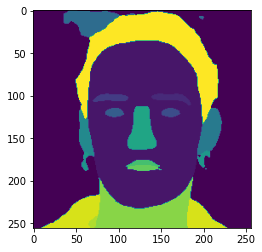

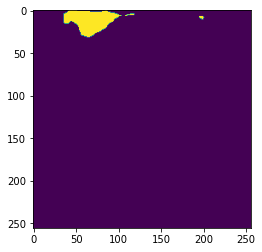

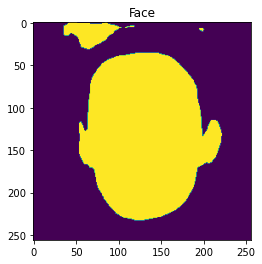

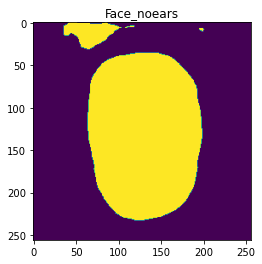

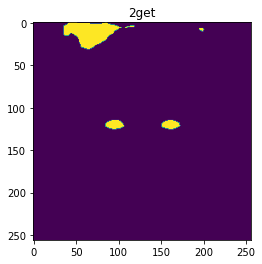

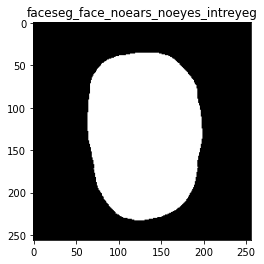

In [55]:
import numpy as np
import torch as th
import matplotlib.pyplot as plt
from PIL import Image
import cv2

def get_mask(face_segment_anno, segment_part):
    face_segment_anno = np.array(face_segment_anno)
    bg = (face_segment_anno == 0)
    skin = (face_segment_anno == 1)
    l_brow = (face_segment_anno == 2)
    r_brow = (face_segment_anno == 3)
    l_eye = (face_segment_anno == 4)
    r_eye = (face_segment_anno == 5)
    eye_g = (face_segment_anno == 6)
    l_ear = (face_segment_anno == 7)
    r_ear = (face_segment_anno == 8)
    ear_r = (face_segment_anno == 9)
    nose = (face_segment_anno == 10)
    mouth = (face_segment_anno == 11)
    u_lip = (face_segment_anno == 12)
    l_lip = (face_segment_anno == 13)
    neck = (face_segment_anno == 14)
    neck_l = (face_segment_anno == 15)
    cloth = (face_segment_anno == 16)
    hair = (face_segment_anno == 17)
    hat = (face_segment_anno == 18)
    # face = np.logical_or.reduce((skin, l_brow, r_brow, l_eye, r_eye, eye_g, l_ear, r_ear, ear_r, nose, mouth, u_lip, l_lip))
    face = np.logical_or.reduce((skin, l_brow, r_brow, l_eye, eye_g, r_eye, l_ear, r_ear, nose, mouth, u_lip, l_lip))
    
    if segment_part == 'faceseg_face':
        seg_m = face
    elif segment_part == 'faceseg_face_neck':
        seg_m = (face | neck)
    elif segment_part == 'faceseg_face_noears':
        seg_m = (~(l_ear | r_ear) & face)
    elif segment_part == 'faceseg_face_noears_noeyes':
        seg_m = (~(l_eye | r_eye | l_ear | r_ear) & face)
    elif segment_part == 'faceseg_face_noears_noeyes_noeyeglasses':
        seg_m = (~(l_eye | r_eye | l_ear | r_ear | eye_g) & face)
    elif segment_part == 'faceseg_face_noears_noeyes_intreyeg':
        # Find contours in the mask
        seg_m = (~(l_eye | r_eye | l_ear | r_ear) & face)
        seg_m = (seg_m * 255).astype(np.uint8)
        contours, _ = cv2.findContours(seg_m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Filter to keep the largest contour, which should correspond to the face
        contour_areas = [cv2.contourArea(c) for c in contours]
        largest_contour_index = np.argmax(contour_areas)
        largest_contour = contours[largest_contour_index]

        # Create an empty mask to draw the largest contour
        filtered_mask = np.zeros_like(seg_m)

        # Draw the largest contour on the mask
        cv2.drawContours(filtered_mask, [largest_contour], -1, (255), thickness=cv2.FILLED)
        seg_m = filtered_mask == 255

    elif segment_part == 'faceseg_face_intreyeg':
        seg_m = (face & eye_g)
    elif segment_part == 'faceseg_head':
        seg_m = (face | neck | hair)
    elif segment_part == 'faceseg_nohead':
        seg_m = ~(face | neck | hair)
    elif segment_part == 'faceseg_face&hair':
        seg_m = ~bg
    elif segment_part == 'faceseg_bg_noface&nohair':
        seg_m = (bg | hat | neck | neck_l | cloth) 
    elif segment_part == 'faceseg_bg&ears_noface&nohair':
        seg_m = (bg | hat | neck | neck_l | cloth) | (l_ear | r_ear | ear_r)
    elif segment_part == 'faceseg_bg':
        seg_m = bg
    elif segment_part == 'faceseg_bg&noface':
        seg_m = (bg | hair | hat | neck | neck_l | cloth)
    elif segment_part == 'faceseg_hair':
        seg_m = hair
    elif segment_part == 'faceseg_faceskin':
        seg_m = skin
    elif segment_part == 'faceseg_faceskin&nose':
        seg_m = (skin | nose)
    elif segment_part == 'faceseg_face_noglasses':
        seg_m = (~eye_g & face)
    elif segment_part == 'faceseg_face_noglasses_noeyes':
        seg_m = (~(l_eye | r_eye) & ~eye_g & face)
    elif segment_part == 'faceseg_eyes&glasses':
        seg_m = (l_eye | r_eye | eye_g)
    elif segment_part == 'faceseg_eyes':
        seg_m = (l_eye | r_eye)
    else: raise NotImplementedError(f"Segment part: {segment_part} is not found!")
    
    out = seg_m
    return out

path = '/data/mint/DPM_Dataset/MultiPIE/MultiPIE_testset/face_segment/valid/anno/'
image = 'anno_169_04_01_051_03.png'
# image = 'anno_208_04_01_051_07.png'

img = Image.open(path + image)
img = np.array(img)
plt.imshow(img)
plt.show()

plt.imshow(img==6)  # Problem with the eye_glasses
plt.show()

mask = get_mask(img, 'faceseg_face')
plt.imshow(mask)
plt.title('Face')
plt.show()

mask = get_mask(img, 'faceseg_face_noears')
plt.imshow(mask)
plt.title('Face_noears')
plt.show()


mask = get_mask(img, 'faceseg_eyes&glasses') & get_mask(img, 'faceseg_face')
plt.imshow(mask)
plt.title('2get')
plt.show()

mask = get_mask(img, 'faceseg_face_noears_noeyes_intreyeg')
np.save('mask.npy', mask)
plt.imshow(mask, cmap='gray')
plt.title('faceseg_face_noears_noeyes_intreyeg')
plt.show()

[False  True]
(256, 256, 1)


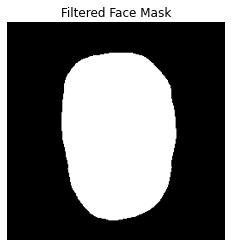

In [52]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the mask image
image_path = "./test.png"
mask = np.load('mask.npy')[..., None]

# Threshold the mask to ensure it's binary
print(np.unique(mask))
binary_mask = (mask * 255).astype(np.uint8)
print(mask.shape)

# Find contours in the mask
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter to keep the largest contour, which should correspond to the face
contour_areas = [cv2.contourArea(c) for c in contours]
largest_contour_index = np.argmax(contour_areas)
largest_contour = contours[largest_contour_index]

# Create an empty mask to draw the largest contour
filtered_mask = np.zeros_like(binary_mask)

# Draw the largest contour on the mask
cv2.drawContours(filtered_mask, [largest_contour], -1, (255), thickness=cv2.FILLED)

# Show the filtered mask
plt.imshow(filtered_mask, cmap='gray')
plt.title("Filtered Face Mask")
plt.axis('off')
plt.show()
